In [1]:
pwd

'C:\\Users\\shuai'

In [2]:
cd C:\Python_temp

C:\Python_temp


In [3]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_widths, savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
# Preprocess the data
def preprocess_data(data, time_column, fluorescence_columns):
    time = data[time_column] * (1200 / data[time_column].max())
    fluorescence_data = data[fluorescence_columns]
    window_size = 120

    # Rolling baseline correction
    rolling_baseline_corrected = fluorescence_data.apply(
        lambda x: (x - x.rolling(window=window_size, min_periods=1, center=True).median()) /
                  x.rolling(window=window_size, min_periods=1, center=True).median(),
        axis=0
    )

    # Apply Savitzky-Golay filter for smoothing
    smoothed_data = rolling_baseline_corrected.apply(
        lambda x: savgol_filter(x, window_length=11, polyorder=3), axis=0
    )

    return time, smoothed_data

In [5]:
# Enhanced Peak Detection for Oscillation Analysis
def enhanced_peak_detection(time, smoothed_data, prominence=0.05, height=0.05, distance=1, width_range=(1, 30)):
    peak_details = []
    for column in smoothed_data.columns:
        # Find peaks with adjustable parameters
        peaks, properties = find_peaks(
            smoothed_data[column],
            prominence=prominence,
            height=height,
            distance=distance
        )
        
        # Calculate peak widths at half-prominence
        widths, width_heights, left_ips, right_ips = peak_widths(smoothed_data[column], peaks, rel_height=0.5)
        
        valid_peaks = []
        for i, peak_idx in enumerate(peaks):
            width_seconds = widths[i] * (time.iloc[1] - time.iloc[0])
            if width_range[0] <= width_seconds <= width_range[1]:
                valid_peaks.append(i)

        total_duration = time.iloc[-1] - time.iloc[0]
        frequency = len(valid_peaks) / 1200*1000

        if len(valid_peaks) == 0:
            # If no valid peaks are detected, fill with 0
            peak_details.append({
                "Region": column,
                "Time": 0,
                "Amplitude": 0,
                "Width": 0,
                "Prominence": 0,
                "Inter_Peak_Interval": 0,
                "Rise_Time": 0,
                "Decay_Time": 0,
                "AUC": 0,
                "Frequency": frequency,
                "Peak_Number": 0
            })
        else:
            for i in valid_peaks:
                peak_idx = peaks[i]
                width_seconds = widths[i] * (time.iloc[1] - time.iloc[0])
                inter_peak_interval = (time.iloc[peak_idx] - time.iloc[peaks[i-1]]) if i > 0 else 0

                # Calculate Rise Time
                left_base_idx = int(left_ips[i])
                rise_time = time.iloc[peak_idx] - time.iloc[left_base_idx]

                # Calculate Decay Time
                right_base_idx = int(right_ips[i])
                decay_time = time.iloc[right_base_idx] - time.iloc[peak_idx]

                # Calculate AUC
                auc = np.trapz(smoothed_data[column].iloc[left_base_idx:right_base_idx+1],
                               time.iloc[left_base_idx:right_base_idx+1])

                peak_details.append({
                    "Region": column,
                    "Time": time.iloc[peak_idx],
                    "Amplitude": properties["peak_heights"][i],
                    "Width": width_seconds,
                    "Prominence": properties["prominences"][i],
                    "Inter_Peak_Interval": inter_peak_interval,
                    "Rise_Time": rise_time,
                    "Decay_Time": decay_time,
                    "AUC": auc,
                    "Frequency": frequency,
                    "Peak_Number": 1
                })

    return pd.DataFrame(peak_details)

In [6]:
def plot_peaks(time, smoothed_data, peak_df, csv_filename=None, save_path=None):
    plt.figure(figsize=(12, 6))

    for column in smoothed_data.columns:
        plt.plot(time, smoothed_data[column], label=f'Region {column}')
        region_peaks = peak_df[peak_df['Region'] == column]
        plt.scatter(region_peaks['Time'], region_peaks['Amplitude'], marker='x')

    plt.title('Calcium Trace with Detected Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('ΔF/F₀')

    # If no save_path but a csv_filename is given, use it to generate filename
    if save_path is None and csv_filename:
        base_name = os.path.splitext(os.path.basename(csv_filename))[0]
        save_path = f"{base_name}_trace_peaks.pdf"

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')

    plt.show()

In [7]:
def plot_peaks_trace_matrix(time, smoothed_data, peak_df=None, n_cols=5, colormap='plasma', csv_filename=None, save_path=None):
    num_rois = len(smoothed_data.columns)
    n_rows = int(np.ceil(num_rois / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 2 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    colors = plt.cm.get_cmap(colormap, num_rois)

    for i, column in enumerate(smoothed_data.columns):
        ax = axes[i]
        color = colors(i)

        ax.plot(time, smoothed_data[column], color=color, linewidth=1)

        if peak_df is not None:
            region_peaks = peak_df[peak_df['Region'] == column]
            ax.scatter(region_peaks['Time'], region_peaks['Amplitude'], color='black', marker='x', s=10)

        ax.set_title(column, fontsize=7)
        ax.tick_params(labelsize=6)

    # Hide unused subplots
    for j in range(num_rois, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Calcium Traces with Detected Peaks (Matrix)', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    # Auto-generate filename using CSV prefix if needed
    if save_path is None and csv_filename:
        base_name = os.path.splitext(os.path.basename(csv_filename))[0]
        save_path = f"{base_name}_trace_matrix.pdf"

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')

    plt.show()

In [8]:
def plot_traces_one_per_row(time, smoothed_data, csv_filename=None, save_path=None, colormap='jet'):
    num_rois = len(smoothed_data.columns)
    fig_width, fig_height = 12, 30  # A4 portrait

    fig, axes = plt.subplots(num_rois, 1, figsize=(fig_width, fig_height), sharex=True)
    if num_rois == 1:
        axes = [axes]

    colors = plt.cm.get_cmap(colormap, num_rois)

    for i, (ax, column) in enumerate(zip(axes, smoothed_data.columns)):
        color = colors(i)
        trace = smoothed_data[column]

        ax.plot(time, trace, color=color, linewidth=1)
        ax.text(-0.02, 0.5, f'{i + 1}', transform=ax.transAxes,
                va='center', ha='right', fontsize=7, color='black')

        ax.set_yticks([])
        ax.set_xticks([])
        ax.tick_params(length=0)
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Time ticks only on bottom row
    axes[-1].set_xticks(np.linspace(time.iloc[0], time.iloc[-1], 6))
    axes[-1].tick_params(labelsize=8)
    axes[-1].set_xlabel('Time (s)', fontsize=10)

    fig.text(0.01, 0.5, 'ΔF/F₀', va='center', rotation='vertical', fontsize=12)

    plt.tight_layout(rect=[0.04, 0, 1, 0.97])

    # Auto-generate save path if needed
    if save_path is None and csv_filename:
        base = os.path.splitext(os.path.basename(csv_filename))[0]
        save_path = f"{base}_traces_one_per_row.pdf"

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')

    plt.show()

In [89]:
# Heatmap of ΔF/F₀ Over Time
def plot_dff_heatmap(time, smoothed_data, csv_filename=None, save_path=None):
    num_rois = smoothed_data.shape[1]  # Number of ROI columns
    
    if save_path is None and csv_filename:
        base_name = os.path.splitext(os.path.basename(csv_filename))[0]
        save_path = f"{base_name}_heatmap.pdf"

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        smoothed_data.T,
        cmap='jet',
        xticklabels=100,
        yticklabels=False,  # 🔁 Hide ROI names
        cbar_kws={'label': 'ΔF/F₀'}#,
        #vmin=-0.2,  # 🔒 fixed lower bound of color scale
        #vmax=1.2    # 🔒 fixed upper bound of color scale
    )
    plt.title(f'Heatmap of ΔF/F₀ Over Time (Total ROIs: {num_rois})')
    plt.xlabel('Time (s)')
    plt.ylabel('Region')

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')

    plt.show()

In [10]:
def export_peak_data(
    peak_df,
    csv_filename,  # <-- required to prefix outputs
    path='.',
    aggregated_filename=None,
    detailed_filename=None
):
    os.makedirs(path, exist_ok=True)
    peak_df.fillna(0, inplace=True)

    # Extract base name from input file (e.g., "GBML198_raw.csv" → "GBML198_raw")
    base = os.path.splitext(os.path.basename(csv_filename))[0]

    # Generate default filenames with CSV prefix
    if detailed_filename is None:
        detailed_filename = f"{base}_detailed_peak_data.csv"
    if aggregated_filename is None:
        aggregated_filename = f"{base}_aggregated_data.csv"

    # Full paths
    detailed_path = os.path.join(path, detailed_filename)
    aggregated_path = os.path.join(path, aggregated_filename)

    # Export detailed data
    peak_df.to_csv(detailed_path, index=False)

    # Aggregate per Region
    aggregated_df = peak_df.groupby('Region').agg({
        'Amplitude': 'mean',
        'Width': 'mean',
        'Prominence': 'mean',
        'Frequency': 'mean',
        'AUC': 'mean',
        'Inter_Peak_Interval': 'mean',
        'Rise_Time': 'mean',
        'Decay_Time': 'mean',
        'Peak_Number': 'sum'
    }).reset_index()

    # Export aggregated
    aggregated_df.to_csv(aggregated_path, index=False)

    print(f"Detailed peak data saved to: {detailed_path}")
    print(f"Aggregated peak data saved to: {aggregated_path}")

In [93]:
csv_file = "50um2_APB.csv"
data = pd.read_csv(csv_file)
print(data.columns)
fluorescence_columns = [col for col in data.columns if col != 'Time']
time, smoothed_data = preprocess_data(data, 'Time', fluorescence_columns)

Index(['Time', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'Mean5', 'Mean6', 'Mean7',
       'Mean8', 'Mean9', 'Mean10', 'Mean11', 'Mean12', 'Mean13', 'Mean14',
       'Mean15', 'Mean16', 'Mean17', 'Mean18', 'Mean19', 'Mean20', 'Mean21',
       'Mean22', 'Mean23', 'Mean24', 'Mean25', 'Mean26', 'Mean27', 'Mean28',
       'Mean29', 'Mean30', 'Mean31', 'Mean32', 'Mean33', 'Mean34', 'Mean35',
       'Mean36', 'Mean37', 'Mean38', 'Mean39', 'Mean40', 'Mean41', 'Mean42',
       'Mean43', 'Mean44', 'Mean45', 'Mean46', 'Mean47', 'Mean48', 'Mean49',
       'Mean50', 'Mean51', 'Mean52', 'Mean53', 'Mean54', 'Mean55', 'Mean56',
       'Mean57', 'Mean58', 'Mean59', 'Mean60', 'Mean61', 'Mean62', 'Mean63',
       'Mean64', 'Mean65', 'Mean66', 'Mean67', 'Mean68', 'Mean69', 'Mean70',
       'Mean71', 'Mean72', 'Mean73', 'Mean74', 'Mean75'],
      dtype='object')


In [96]:
peak_df = enhanced_peak_detection(time, smoothed_data, prominence=0.05, height=0.05, distance=1, width_range=(1, 60))

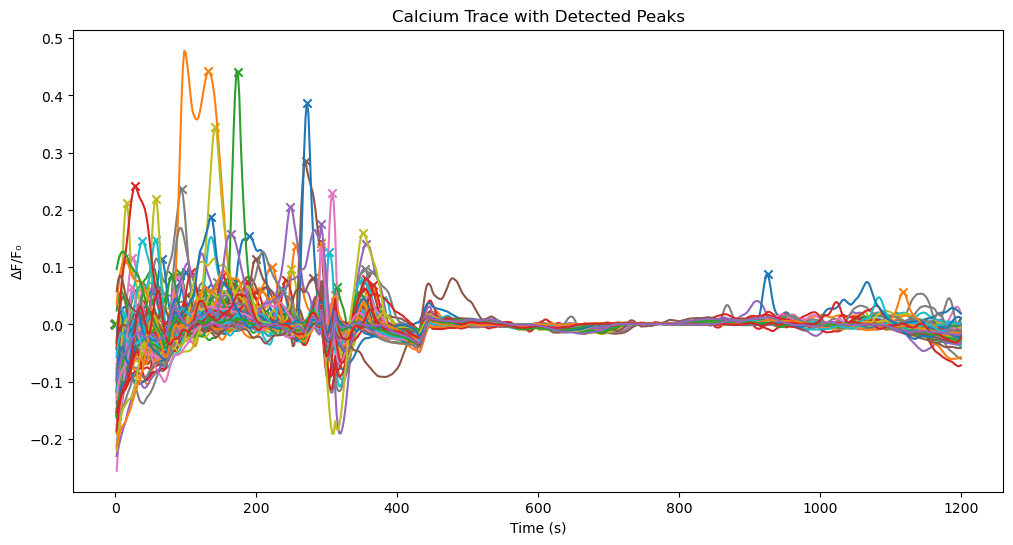

In [97]:
plot_peaks(time, smoothed_data, peak_df, csv_filename=csv_file)

C:\Users\shuai\AppData\Local\Temp\ipykernel_6748\125670257.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, num_rois)


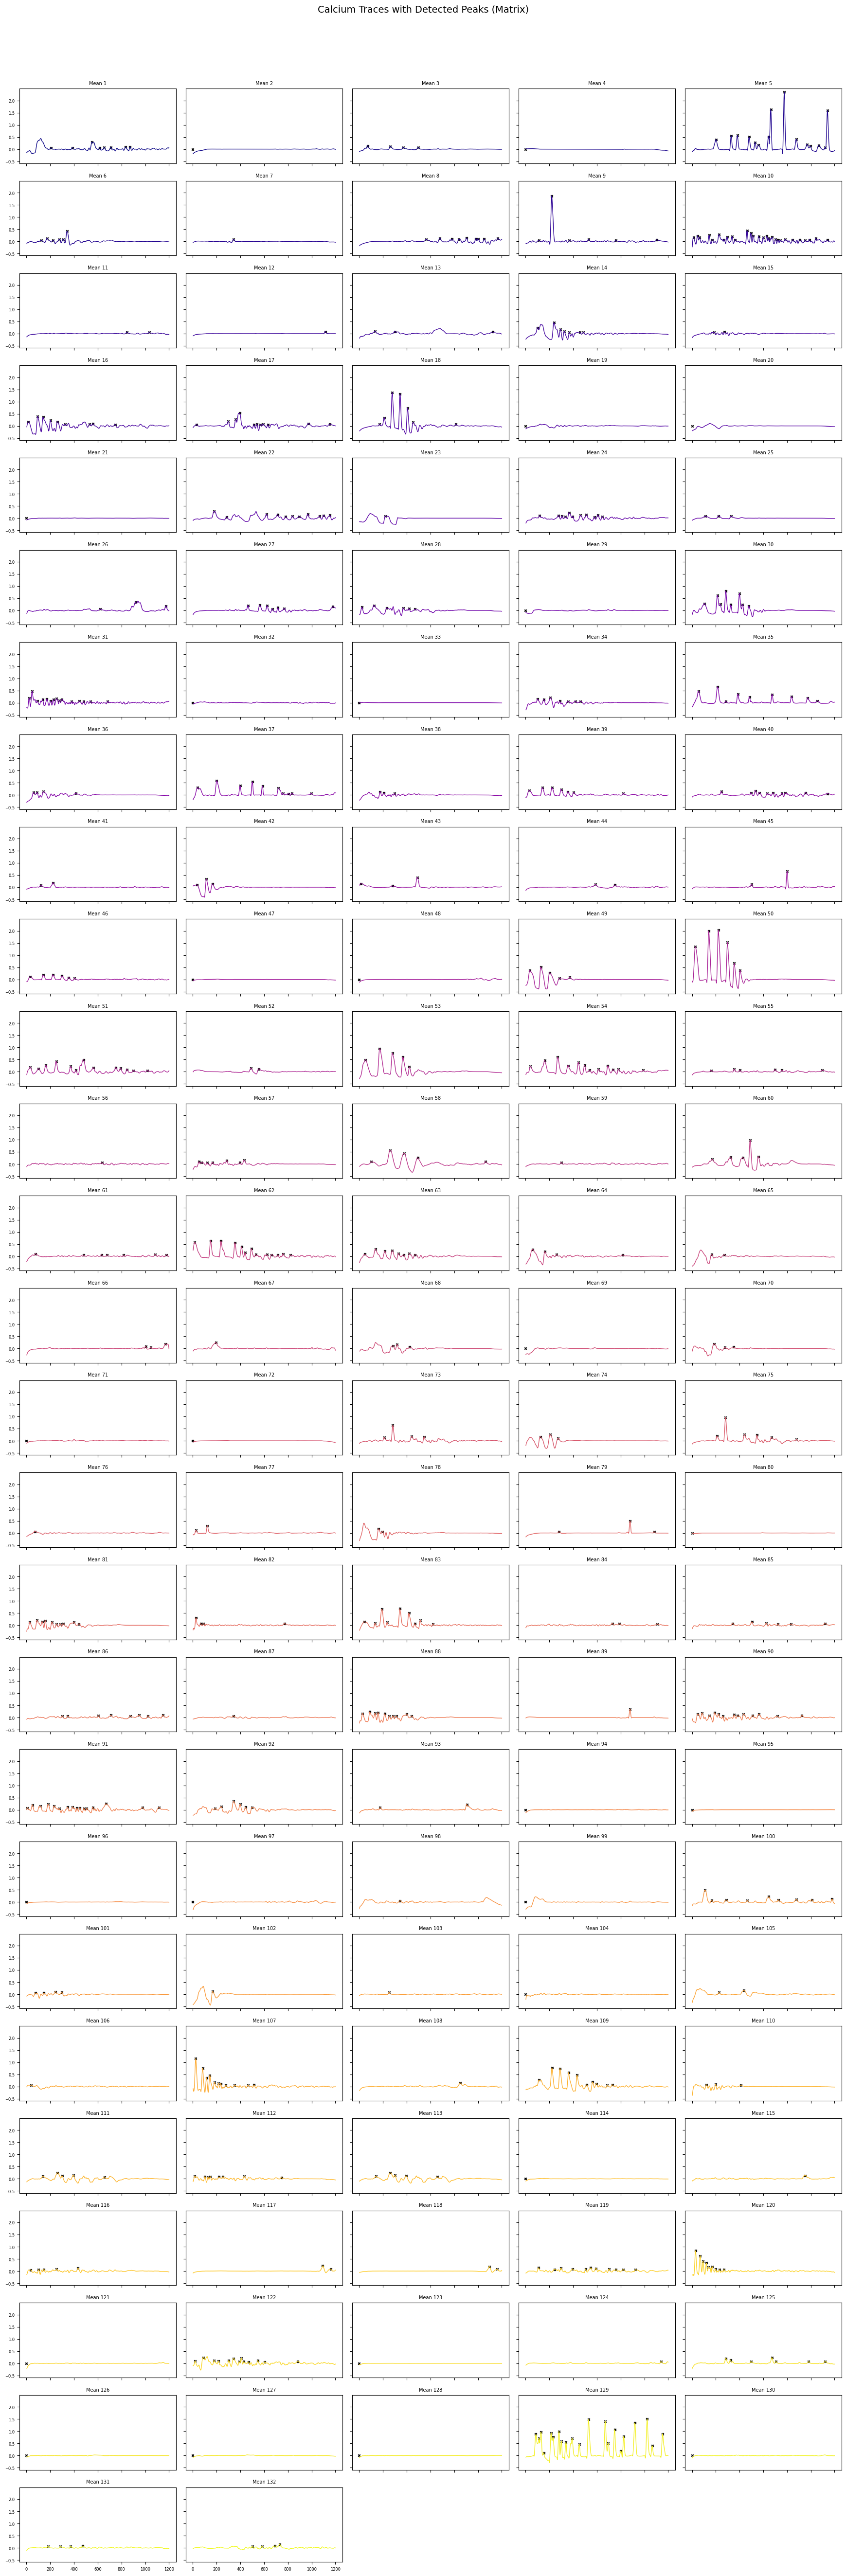

In [72]:
plot_peaks_trace_matrix(time, smoothed_data, peak_df, csv_filename=csv_file)

C:\Users\shuai\AppData\Local\Temp\ipykernel_6748\2113070981.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, num_rois)


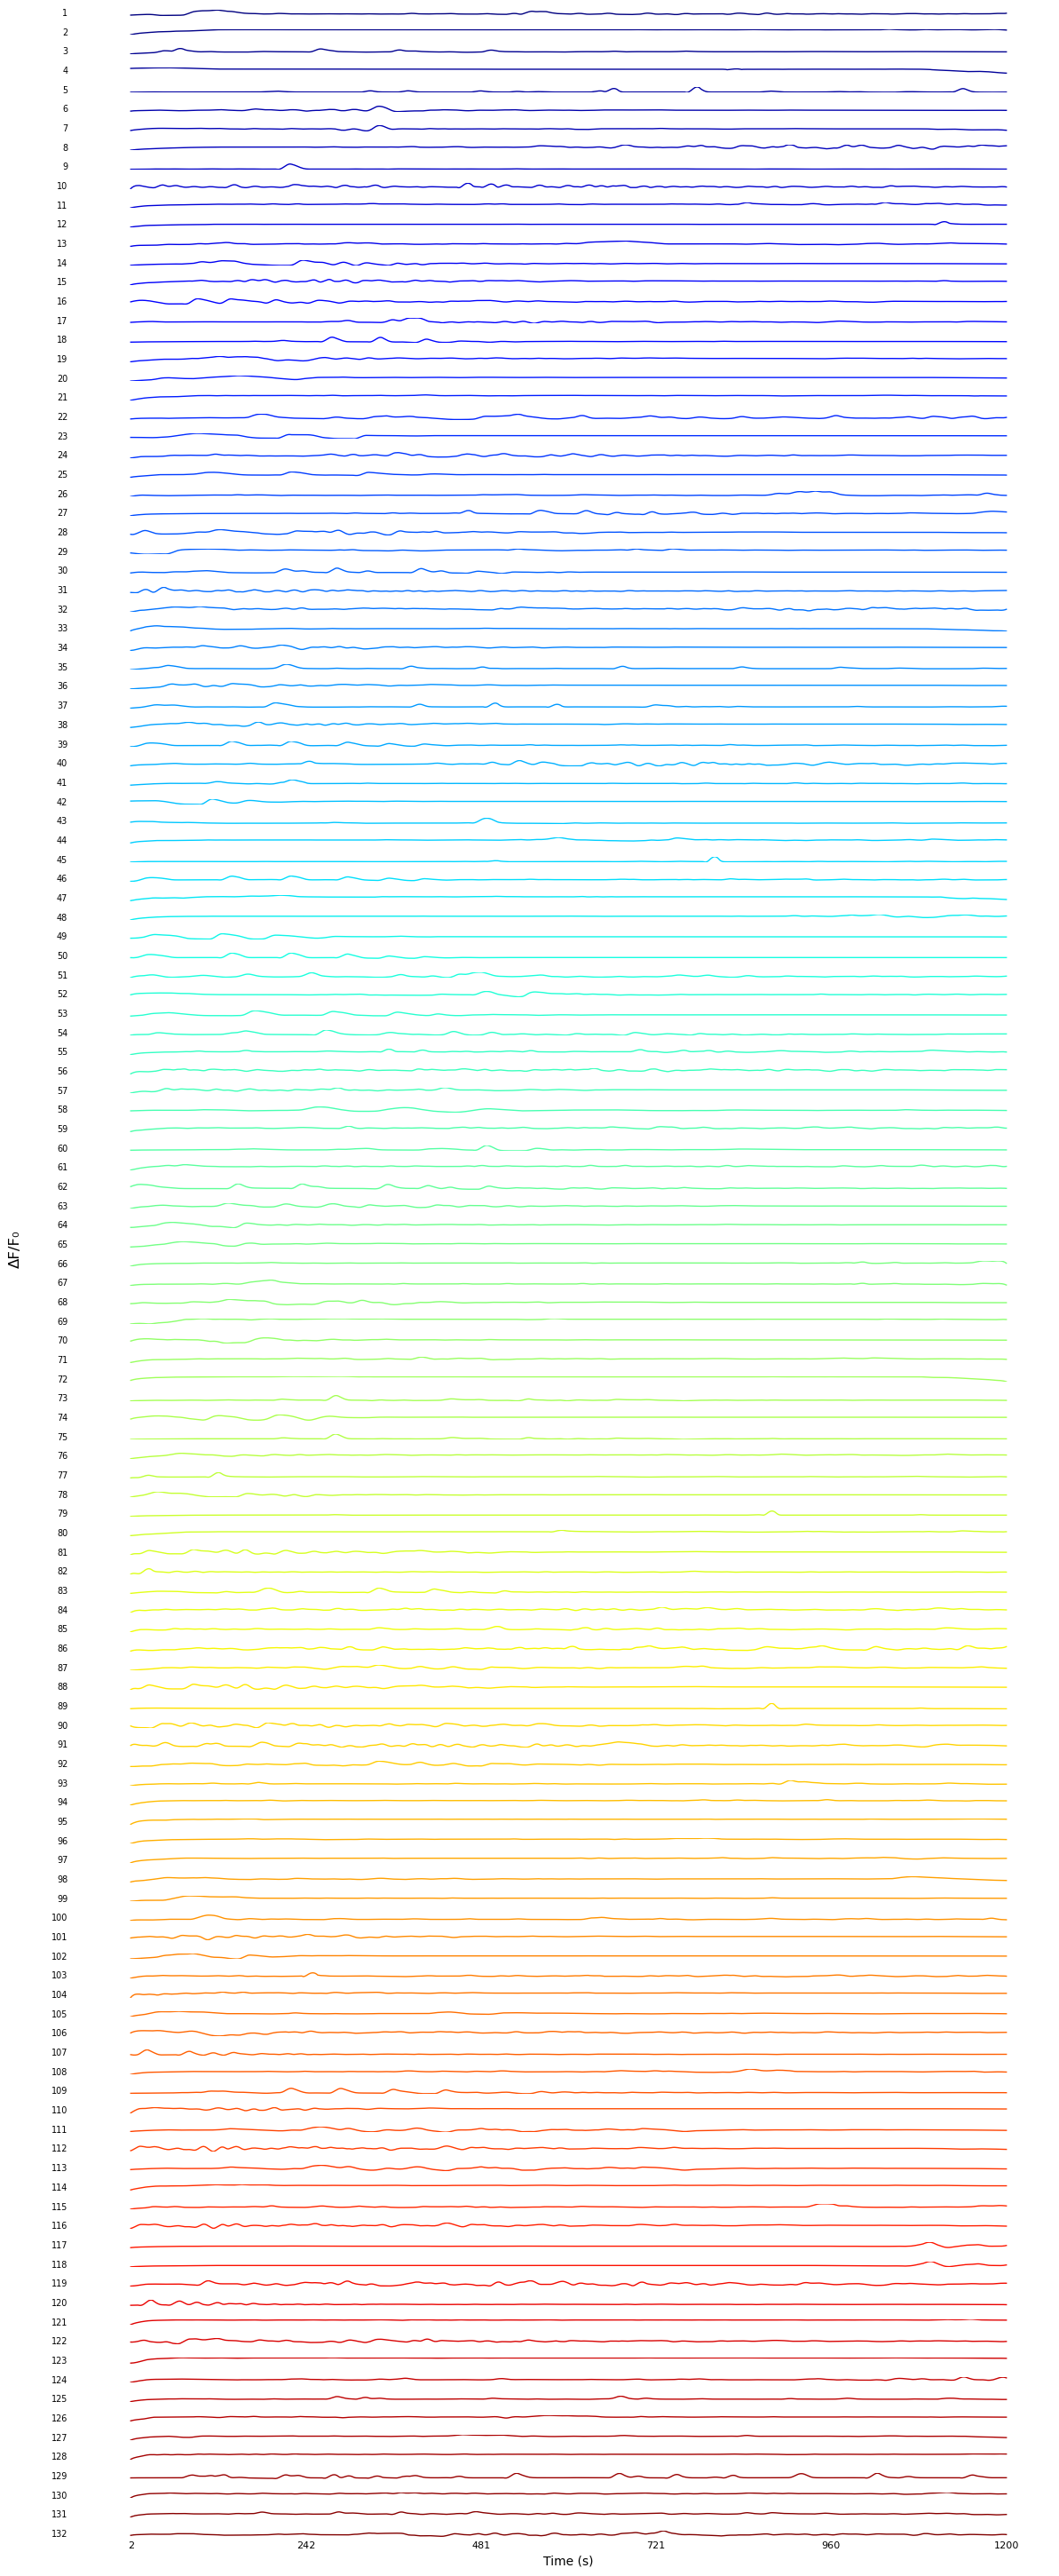

In [73]:
plot_traces_one_per_row(time, smoothed_data, csv_filename=csv_file)

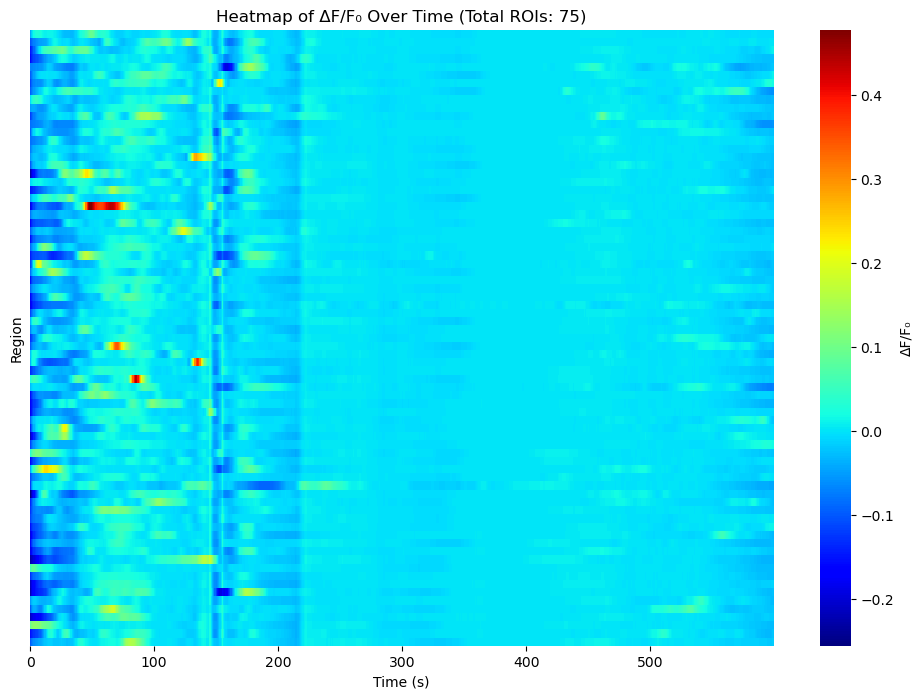

In [94]:
plot_dff_heatmap(time, smoothed_data, csv_filename=csv_file)

In [86]:
export_peak_data(peak_df,csv_filename=csv_file)

Detailed peak data saved to: .\NSC_3GCaMP6f_detailed_peak_data.csv
Aggregated peak data saved to: .\NSC_3GCaMP6f_aggregated_data.csv


In [76]:
print(peak_df.head())

   Region   Time  Amplitude      Width  Prominence  Inter_Peak_Interval  \
0  Mean 1  206.0   0.050235  15.414894    0.063560                 86.0   
1  Mean 1  386.0   0.059633  15.201944    0.081592                180.0   
2  Mean 1  552.0   0.292836  36.097963    0.349899                166.0   
3  Mean 1  616.0   0.057740  11.863796    0.077514                 64.0   
4  Mean 1  654.0   0.068900  14.425125    0.113055                 38.0   

   Rise_Time  Decay_Time       AUC  Frequency  Peak_Number  
0       10.0         6.0  0.603720   6.666667            1  
1        8.0         8.0  0.688385   6.666667            1  
2       10.0        26.0  8.622876   6.666667            1  
3        8.0         4.0  0.505778   6.666667            1  
4        8.0         8.0  0.700830   6.666667            1  
